# Diabetes Prediction & Risk Analysis — Final Organized Notebook

Run sequentially in Colab. The notebook expects `/content/diabetes.csv` to exist.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## STEP 1 / UNIT 1 — Import & Install (run once)

In [ ]:
!pip install -q xgboost==1.7.6 shap==0.42.1 mlxtend==0.21.0 umap-learn==0.5.4 imbalanced-learn==0.10.1 tensorflow==2.12.0
print('Install complete')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.7/402.7 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
Install complete


## STEP 1: Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import xgboost as xgb
import shap
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import joblib
sns.set_style('whitegrid')
print('Libraries loaded')


Libraries loaded


## STEP 2 / UNIT 1 — Load Dataset
Load dataset from `/content/diabetes.csv` (upload in Colab if needed).

In [ ]:
path = '/content/diabetes.csv'
if not os.path.exists(path):
    raise FileNotFoundError('Please upload diabetes.csv to /content/')
df = pd.read_csv(path)
print('Loaded, shape =', df.shape)
df.head()


Loaded, shape = (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## STEP 3 / UNIT 1 — Data Preprocessing
Replace zeros with NaN for certain cols, impute, and create categorical bins.

In [ ]:
cols_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_zero:
    if c in df.columns:
        print(c, 'zeros:', (df[c]==0).sum())

# Replace & impute
df[cols_zero] = df[cols_zero].replace(0, np.nan)
imputer = SimpleImputer(strategy='median')
df[cols_zero] = imputer.fit_transform(df[cols_zero])

# Feature engineering
df['AgeGroup'] = pd.cut(df['Age'], bins=[20,30,40,50,60,100], labels=['21-30','31-40','41-50','51-60','60+'])
df['BMI_cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100], labels=['Underweight','Normal','Overweight','Obese'])
df['Glucose_cat'] = pd.cut(df['Glucose'], bins=[0,80,126,1000], labels=['Low','Prediabetes','High'])

print('Imputation done')
df.head()


Glucose zeros: 5
BloodPressure zeros: 35
SkinThickness zeros: 227
Insulin zeros: 374
BMI zeros: 11
Imputation done


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMI_cat,Glucose_cat
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,41-50,Obese,High
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,31-40,Overweight,Prediabetes
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,31-40,Normal,High
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,21-30,Overweight,Prediabetes
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,31-40,Obese,High


## STEP 4 / UNIT 2 — EDA & Visualization
This section includes your previous visualizations and new cleaned visuals; both are placed where appropriate.

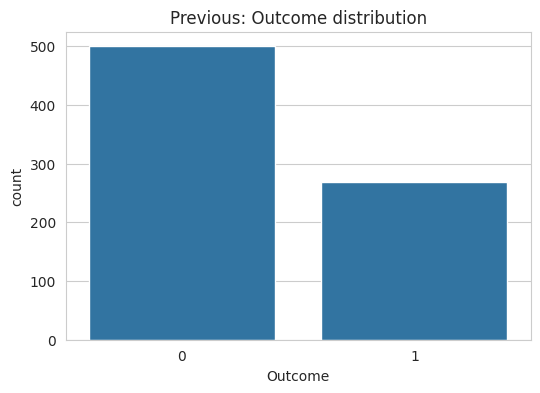

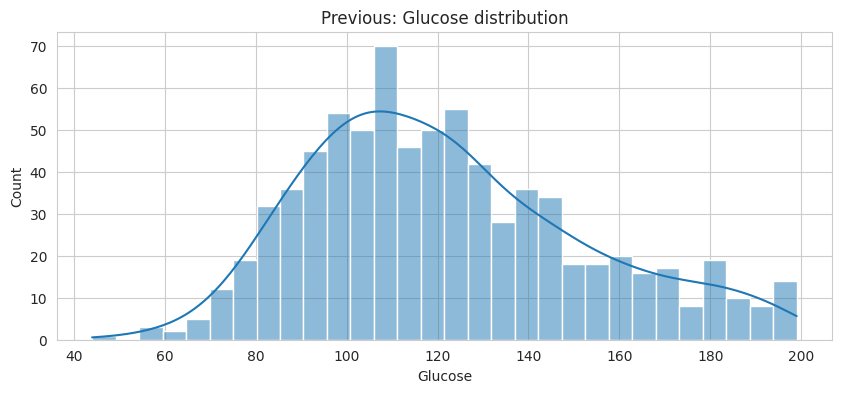

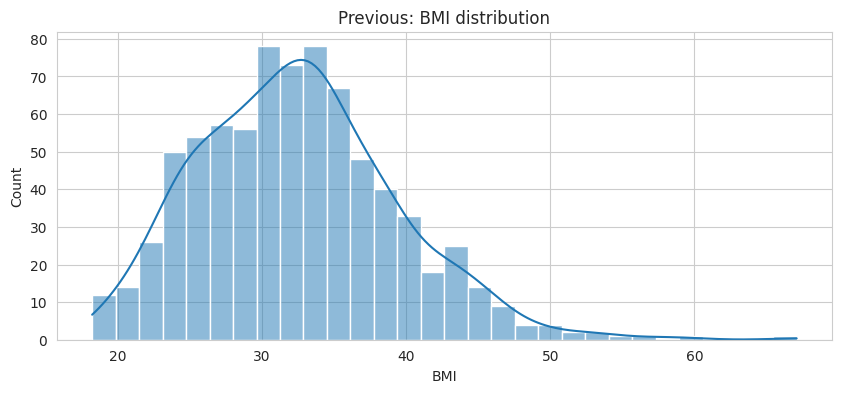

In [ ]:
# Previous visualizations (kept)
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title('Previous: Outcome distribution')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['Glucose'], bins=30, kde=True)
plt.title('Previous: Glucose distribution')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['BMI'], bins=30, kde=True)
plt.title('Previous: BMI distribution')
plt.show()


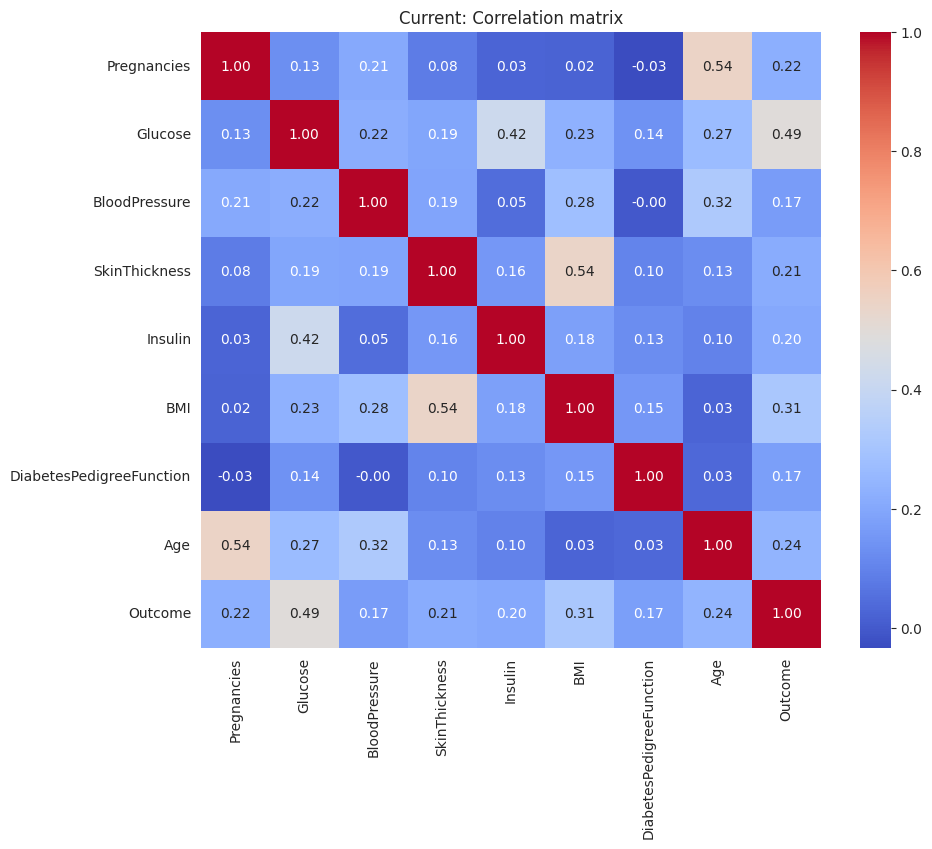

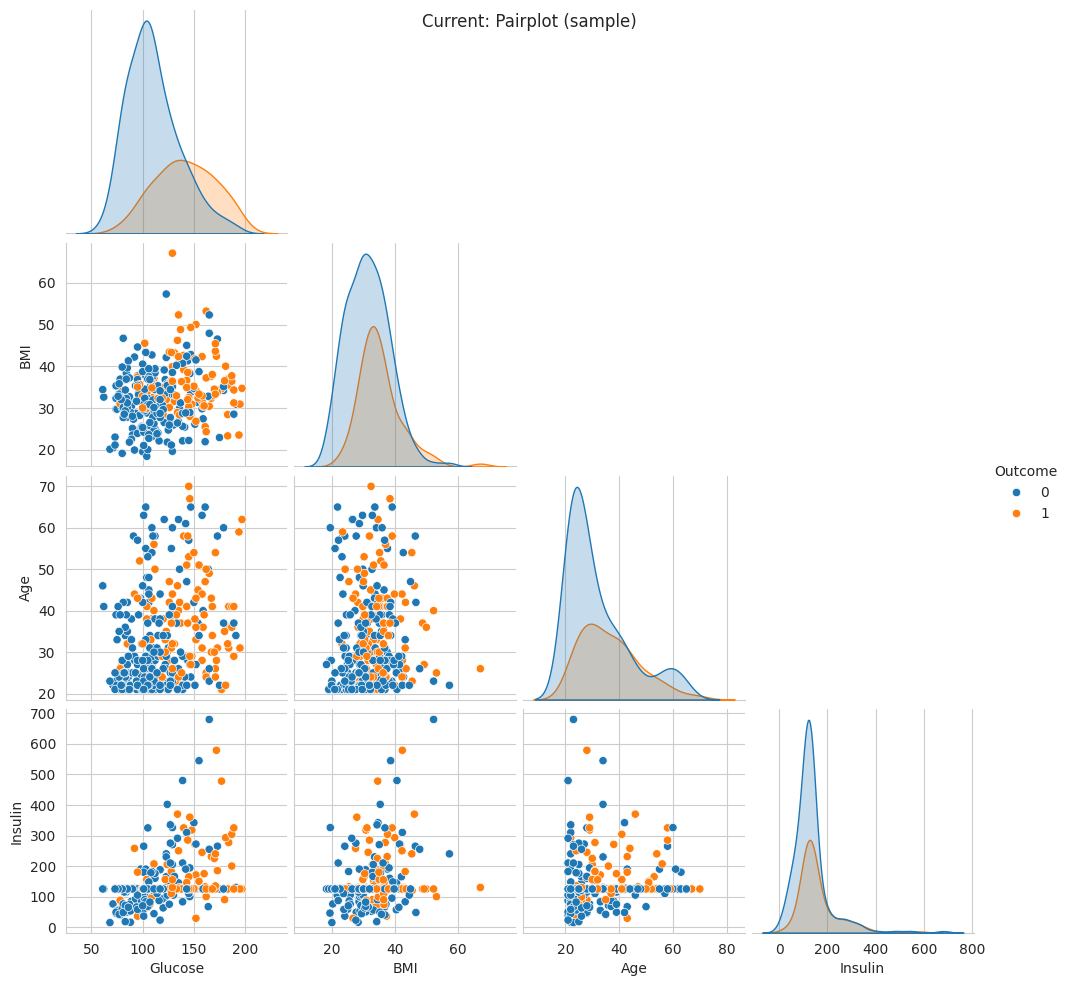

Current: Diabetes prevalence by AgeGroup and BMI_cat


BMI_cat,Underweight,Normal,Overweight,Obese
AgeGroup,,,,
21-30,0.0,0.014,0.120,0.316
31-40,0.0,0.118,0.341,0.606
41-50,0.0,0.167,0.684,0.568
51-60,0.0,0.250,0.444,0.727
60+,0.0,0.000,0.091,0.500


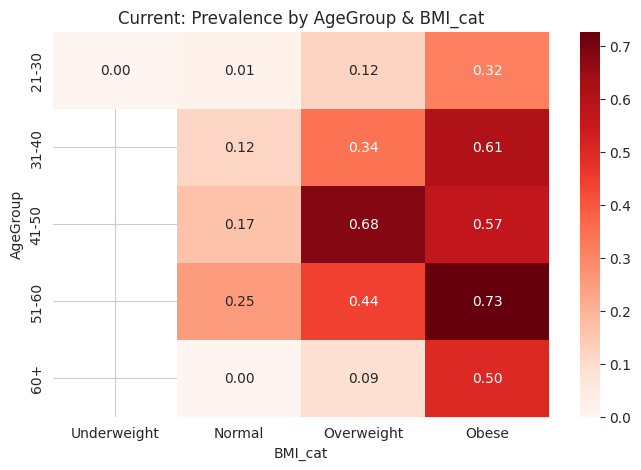

In [ ]:
# Current visualizations (clean)
plt.figure(figsize=(10,8))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Current: Correlation matrix')
plt.show()

# Pairplot sample for speed
sample = df.sample(frac=0.4, random_state=42)
sns.pairplot(sample[['Glucose','BMI','Age','Insulin','Outcome']], hue='Outcome', corner=True)
plt.suptitle('Current: Pairplot (sample)')
plt.show()

# OLAP pivot
pivot = pd.pivot_table(df, values='Outcome', index='AgeGroup', columns='BMI_cat', aggfunc=np.mean)
print('Current: Diabetes prevalence by AgeGroup and BMI_cat')
display(pivot.fillna(0).round(3))
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='Reds')
plt.title('Current: Prevalence by AgeGroup & BMI_cat')
plt.show()

## STEP 5 / UNIT 3 — Association Rules & Apriori (previous + current)

In [ ]:
# Prepare categorical transactions
trans = pd.DataFrame()
trans['AgeGroup'] = 'Age_' + df['AgeGroup'].astype(str)
trans['BMI_cat'] = 'BMI_' + df['BMI_cat'].astype(str)
trans['Glucose_cat'] = 'Glu_' + df['Glucose_cat'].astype(str)
trans['Outcome'] = np.where(df['Outcome']==1, 'Diabetes_Yes', 'Diabetes_No')
one_hot = pd.get_dummies(trans)

# Apriori (current)
freq_items = apriori(one_hot, min_support=0.06, use_colnames=True)
print('Frequent itemsets (current):')
display(freq_items.sort_values('support', ascending=False).head(10))

rules = association_rules(freq_items, metric='lift', min_threshold=1.2)
print('Top rules (current):')
display(rules.sort_values(['lift','confidence'], ascending=False)[['antecedents','consequents','support','confidence','lift']].head(10))


Frequent itemsets (current):


,support,itemsets
9,0.651042,(Outcome_Diabetes_No)
5,0.619792,(BMI_cat_BMI_Obese)
8,0.570312,(Glucose_cat_Glu_Prediabetes)
0,0.542969,(AgeGroup_Age_21-30)
39,0.450521,"(Glucose_cat_Glu_Prediabetes, Outcome_Diabetes..."
16,0.425781,"(Outcome_Diabetes_No, AgeGroup_Age_21-30)"
7,0.375000,(Glucose_cat_Glu_High)
15,0.356771,"(Glucose_cat_Glu_Prediabetes, AgeGroup_Age_21-30)"
10,0.348958,(Outcome_Diabetes_Yes)
32,0.337240,"(Outcome_Diabetes_No, BMI_cat_BMI_Obese)"


Top rules (current):


,antecedents,consequents,support,confidence,lift
104,"(Outcome_Diabetes_Yes, AgeGroup_Age_21-30)","(Glucose_cat_Glu_High, BMI_cat_BMI_Obese)",0.066406,0.566667,2.072381
105,"(Glucose_cat_Glu_High, BMI_cat_BMI_Obese)","(Outcome_Diabetes_Yes, AgeGroup_Age_21-30)",0.066406,0.242857,2.072381
80,"(Glucose_cat_Glu_High, BMI_cat_BMI_Obese)",(Outcome_Diabetes_Yes),0.192708,0.704762,2.019616
81,(Outcome_Diabetes_Yes),"(Glucose_cat_Glu_High, BMI_cat_BMI_Obese)",0.192708,0.552239,2.019616
62,"(Glucose_cat_Glu_High, AgeGroup_Age_31-40)",(Outcome_Diabetes_Yes),0.061198,0.691176,1.980685
63,(Outcome_Diabetes_Yes),"(Glucose_cat_Glu_High, AgeGroup_Age_31-40)",0.061198,0.175373,1.980685
82,(Glucose_cat_Glu_High),"(Outcome_Diabetes_Yes, BMI_cat_BMI_Obese)",0.192708,0.513889,1.818740
79,"(Outcome_Diabetes_Yes, BMI_cat_BMI_Obese)",(Glucose_cat_Glu_High),0.192708,0.682028,1.818740
101,"(Outcome_Diabetes_Yes, AgeGroup_Age_21-30, BMI...",(Glucose_cat_Glu_High),0.066406,0.662338,1.766234
108,(Glucose_cat_Glu_High),"(Outcome_Diabetes_Yes, AgeGroup_Age_21-30, BMI...",0.066406,0.177083,1.766234


## STEP 6 / UNIT 4 — Modeling (Decision Tree, Random Forest, XGBoost)
Organized modeling cell; previous model outputs are preserved here in the same order.

Decision Tree report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       100
           1       0.70      0.69      0.69        54

    accuracy                           0.79       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.79      0.79       154

Random Forest report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       100
           1       0.71      0.54      0.61        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154

XGBoost report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg  

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,Random Forest,0.759740,0.707317,0.537037,0.610526,0.811296
2,XGBoost,0.759740,0.673469,0.611111,0.640777,0.808148
0,Decision Tree,0.785714,0.698113,0.685185,0.691589,0.788704


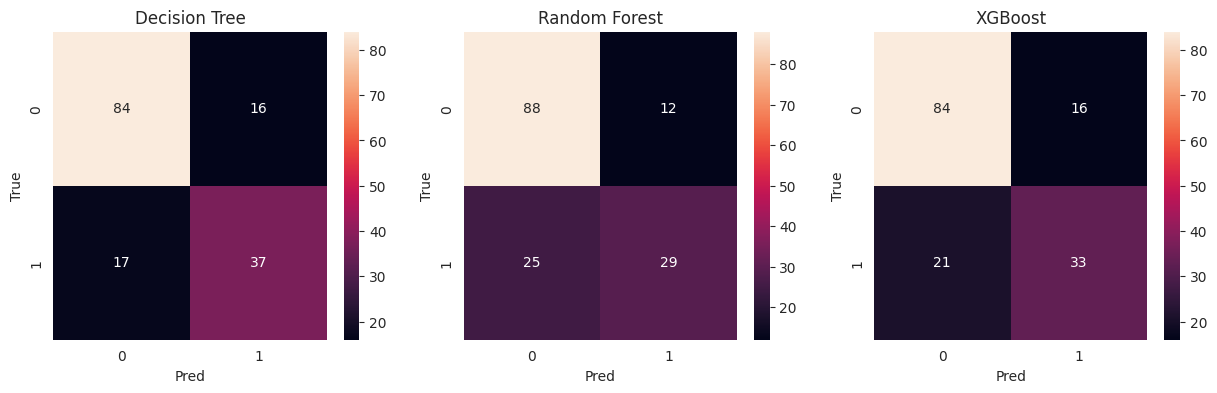

In [ ]:
# Prepare data
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
X = df[features]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

results = {}

# Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train_s, y_train)
y_pred_dt = dt.predict(X_test_s)
y_proba_dt = dt.predict_proba(X_test_s)[:,1]
results['Decision Tree'] = {'model': dt, 'y_pred': y_pred_dt, 'y_proba': y_proba_dt}
print('Decision Tree report:')
print(classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)
y_proba_rf = rf.predict_proba(X_test_s)[:,1]
results['Random Forest'] = {'model': rf, 'y_pred': y_pred_rf, 'y_proba': y_proba_rf}
print('Random Forest report:')
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_s, y_train)
y_pred_xgb = xgb_clf.predict(X_test_s)
y_proba_xgb = xgb_clf.predict_proba(X_test_s)[:,1]
results['XGBoost'] = {'model': xgb_clf, 'y_pred': y_pred_xgb, 'y_proba': y_proba_xgb}
print('XGBoost report:')
print(classification_report(y_test, y_pred_xgb))

# Summary table
summary = []
for name, res in results.items():
    acc = accuracy_score(y_test, res['y_pred'])
    prec = precision_score(y_test, res['y_pred'])
    rec = recall_score(y_test, res['y_pred'])
    f1 = f1_score(y_test, res['y_pred'])
    auc = roc_auc_score(y_test, res['y_proba'])
    summary.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC_AUC': auc})
summary_df = pd.DataFrame(summary).sort_values('ROC_AUC', ascending=False)
display(summary_df)

# Confusion matrices
fig, axes = plt.subplots(1, len(results), figsize=(15,4))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Pred')
    ax.set_ylabel('True')
plt.show()


### STEP 6b: Clustering (additional) — keep previous and current clustering

Silhouette scores: {2: np.float64(0.2780368645773449), 3: np.float64(0.24691300454576234), 4: np.float64(0.211448644769503), 5: np.float64(0.19510703796723958)}
Best k: 2


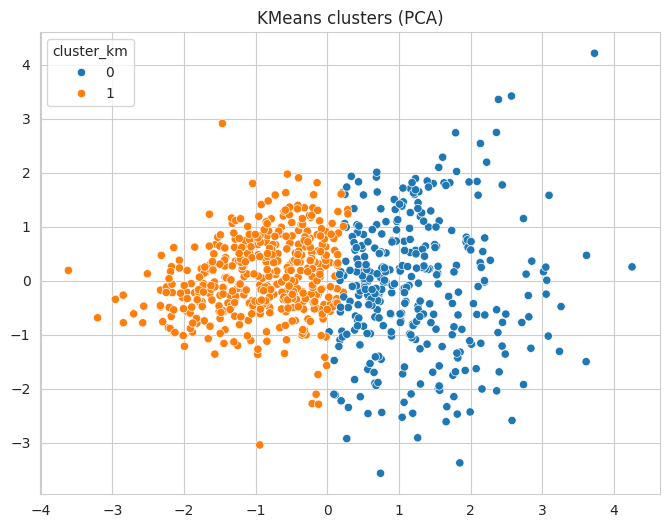

,Glucose,BMI,Age,BloodPressure,Outcome
cluster_km,,,,,
0,142.44,35.66,41.09,79.83,0.57
1,105.83,30.02,27.26,66.72,0.18


In [ ]:
# KMeans clustering
cluster_features = ['Glucose','BMI','Age','BloodPressure']
Xc = df[cluster_features].fillna(df[cluster_features].median())
Xc_s = StandardScaler().fit_transform(Xc)
from sklearn.metrics import silhouette_score
scores = {}
for k in range(2,6):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(Xc_s)
    scores[k] = silhouette_score(Xc_s, labels)
print('Silhouette scores:', scores)
best_k = max(scores, key=scores.get)
print('Best k:', best_k)
km = KMeans(n_clusters=best_k, random_state=42).fit(Xc_s)
df['cluster_km'] = km.labels_

pca = PCA(n_components=2)
proj = pca.fit_transform(Xc_s)
plt.figure(figsize=(8,6))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=df['cluster_km'], palette='tab10')
plt.title('KMeans clusters (PCA)')
plt.show()

display(df.groupby('cluster_km')[cluster_features + ['Outcome']].mean().round(2))


## STEP 7 / UNIT 5 — Risk Analysis (Rule-based & Model-based)
Both previous rule and current model-based probabilities included.

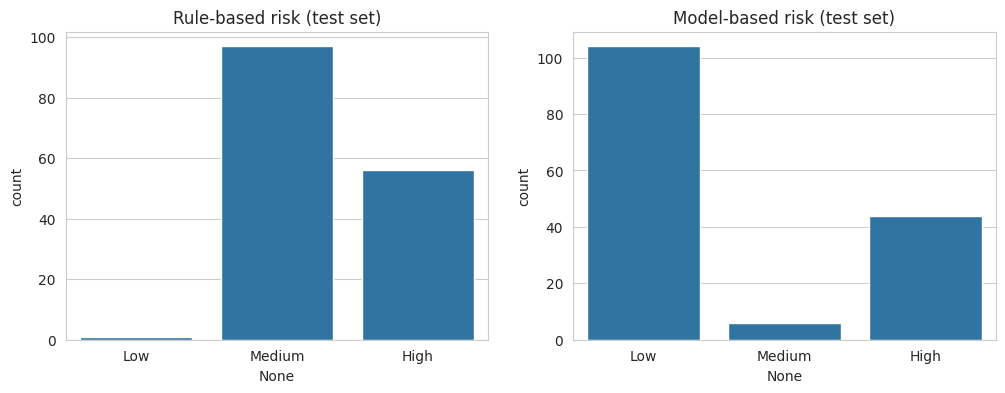

,Glucose,BMI,Age,RuleScore,RuleBucket,ModelProb,ModelBucket,True
0,159.0,27.4,40,66.0,High,1.000000,High,0
1,68.0,35.5,47,49.0,Medium,0.000000,Low,0
2,122.0,35.9,26,56.7,Medium,0.000000,Low,0
3,114.0,27.4,34,52.8,Medium,0.398607,Low,1
4,74.0,32.3,22,41.6,Medium,0.000000,Low,0
5,100.0,31.6,28,49.6,Medium,0.000431,Low,0
6,105.0,43.3,45,61.8,High,0.253474,Low,1
7,197.0,25.9,39,74.6,High,0.967858,High,1
8,100.0,29.7,21,46.6,Medium,0.000000,Low,0
9,165.0,47.9,26,73.7,High,1.000000,High,0


In [ ]:
# Rule-based scoring (simple normalized weighted sum)
rb_score = (0.5 * (X_test['Glucose'] / X_test['Glucose'].max()) +
            0.3 * (X_test['BMI'] / X_test['BMI'].max()) +
            0.2 * (X_test['Age'] / X_test['Age'].max()))
rb_score = (rb_score * 100).round(1)

def rb_bucket(s):
    if s >= 60:
        return 'High'
    elif s >= 35:
        return 'Medium'
    else:
        return 'Low'
rb_buckets = rb_score.apply(rb_bucket)

# Model-based using XGBoost probabilities (isotonic calibration)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_s, y_train, test_size=0.2, random_state=42)
val_probs = xgb_clf.predict_proba(X_val)[:,1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_probs, y_val)
xgb_probs_raw = xgb_clf.predict_proba(X_test_s)[:,1]
xgb_probs_cal = iso.transform(xgb_probs_raw)

def mb_bucket(p):
    if p >= 0.7:
        return 'High'
    elif p >= 0.4:
        return 'Medium'
    else:
        return 'Low'
mb_buckets = pd.Series(xgb_probs_cal).apply(mb_bucket)

# Visualize
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x=rb_buckets, order=['Low','Medium','High'], ax=axes[0])
axes[0].set_title('Rule-based risk (test set)')
sns.countplot(x=mb_buckets, order=['Low','Medium','High'], ax=axes[1])
axes[1].set_title('Model-based risk (test set)')
plt.show()

# Comparison table
compare = X_test.reset_index(drop=True).loc[:11, ['Glucose','BMI','Age']].copy()
compare['RuleScore'] = rb_score.reset_index(drop=True).loc[:11]
compare['RuleBucket'] = rb_buckets.reset_index(drop=True).loc[:11]
compare['ModelProb'] = xgb_probs_cal[:12]
compare['ModelBucket'] = mb_buckets[:12]
compare['True'] = y_test.reset_index(drop=True).loc[:11]
display(compare)
